In [1]:
# !pip install openpyxl

In [2]:
import os
import tqdm
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from fvcore.nn import FlopCountAnalysis
from einops.layers.torch import Rearrange
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class PositionalEmbedding(nn.Module):
#     def __init__(self, num_patches, projection_dim):
#         super(PositionalEmbedding, self).__init__()
#         self.embedding = nn.Embedding(num_patches, projection_dim)

#     def forward(self, x):
#         positions = torch.arange(x.shape[1], device=x.device).unsqueeze(0)
#         encoded_positions = self.embedding(positions)
#         return x + encoded_positions

# class MLP(nn.Module):
#     def __init__(self, input_dim, hidden_units, dropout_rate):
#         super(MLP, self).__init__()
#         layers = []
#         for units in hidden_units:
#             layers.extend([
#                 nn.Linear(input_dim, units),
#                 nn.GELU(),
#                 nn.Dropout(dropout_rate)
#             ])
#             input_dim = units
#         self.mlp = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.mlp(x)

class TokenLearner(nn.Module):
    def __init__(self, num_tokens):
        super(TokenLearner, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_tokens, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_tokens, out_channels=num_tokens, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=num_tokens, out_channels=num_tokens, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=num_tokens, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # print("TokenLearner")
        # print(x.shape)
        # x = F.tanh(self.conv1(x))
        x = self.conv1(x)
        # print(x.shape)
        # x = F.tanh(self.conv2(x))
        x = self.conv2(x)
        # print(x.shape)
        # x = F.tanh(self.conv3(x))
        x = self.conv3(x)
        # print(x.shape)
        # x = F.tanh(self.conv4(x))
        x = self.conv4(x)
        # print(x.shape)
        # x = x.view(x.size(0), x.size(1), -1)
        # print(x.shape)
        # x = x.permute(0, 2, 1)  # Permute to match TensorFlow's behavior
        # print(x.shape)
        # print("TokenLearner Done")
        return x

# class Transformer(nn.Module):
#     def __init__(self, input_dim, num_heads, mlp_units, dropout_rate):
#         super(Transformer, self).__init__()
#         self.multihead_attention = nn.MultiheadAttention(input_dim, num_heads, dropout=dropout_rate)
#         self.mlp = MLP(input_dim, mlp_units, dropout_rate)

#     def forward(self, x):
#         # print("Transformer")
#         # print(x.shape)
#         attention_output, _ = self.multihead_attention(x, x, x)
#         # print(x.shape)
#         x = x + attention_output
#         # print(x.shape)
#         x = x + self.mlp(x)
#         # print(x.shape)
#         return x

# class ViTClassifier(nn.Module):
#     def __init__(self, image_size, patch_size, num_patches, projection_dim, num_heads, mlp_units, dropout_rate, num_classes, use_token_learner=False, token_learner_units=1):
#         super(ViTClassifier, self).__init__()
#         self.patch_embedding = nn.Conv2d(in_channels=1, out_channels=projection_dim, kernel_size=patch_size, stride=patch_size)
#         self.positional_embedding = PositionalEmbedding(num_patches, projection_dim)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.transformer_layers = nn.ModuleList([Transformer(projection_dim, num_heads, mlp_units, dropout_rate) for _ in range(4)])
#         self.use_token_learner = use_token_learner
#         self.token_learner = TokenLearner(token_learner_units) if use_token_learner else None
#         self.layer_norm = nn.LayerNorm(projection_dim)
#         # self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         # self.classifier = nn.Linear(projection_dim, num_classes)
#         self.projection_dim = projection_dim

#     def forward(self, x):
#         # print(x.shape)
#         x = self.patch_embedding(x)
#         B, _, H, W = x.shape
#         # print(x.shape)
#         x = x.flatten(2).transpose(1, 2)
#         # print(x.shape)
#         x = self.positional_embedding(x)
#         # print(x.shape)
#         x = self.dropout(x)
#         # print(x.shape)
        
#         for idx, transformer in enumerate(self.transformer_layers):
#             x = transformer(x)
            
#             if idx == len(self.transformer_layers) // 2:
#                 if self.use_token_learner:
#                     x = x.permute(0, 2, 1).unsqueeze(1)  # Adjust shape for TokenLearner
#                     # print(x.shape)
#                     x = self.token_learner(x)
#                     # print(x.shape)
#                     x = x.squeeze(1).permute(0, 2, 1)

#             # print(x.shape)
#         # print(x.shape)

#         # if self.use_token_learner:
#         #     x = x.permute(0, 2, 1).unsqueeze(1)  # Adjust shape for TokenLearner
#         #     # print(x.shape)
#         #     x = self.token_learner(x)
#         #     # print(x.shape)
#         #     x = x.squeeze(1).permute(0, 2, 1)  # Adjust shape back
#             # print(x.shape)
        
#         # print(x.shape)
#         return x
        
#         # x = self.layer_norm(x)
#         # x = self.global_avg_pool(x).squeeze(2)
#         # x = self.classifier(x)
#         # return x


In [4]:
class ViTBlock(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size, num_patches, hidden_dim, num_heads, mlp_dim, dropout=0.1):
        super(ViTBlock, self).__init__()
        self.patch_embedding = nn.Conv2d(in_channels, out_channels, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches, out_channels))
        self.cls_token = nn.Parameter(torch.randn(1, 1, out_channels))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(out_channels, num_heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True), num_layers=3)
        self.dropout = nn.Dropout(dropout)
        self.token_learner = TokenLearner(10)

    def forward(self, x):
        # print("New Call")
        
        # print("Encoder 1", x.shape)
        B, C, H, W = x.shape
        x = self.patch_embedding(x)  # B, out_channels, H', W'
        # print("Encoder 2", x.shape)
        
        x = x.flatten(2).transpose(1, 2)  # B, (H' * W'), out_channels
        # print("Encoder 3", x.shape)
        
        # cls_tokens = self.cls_token.expand(B, -1, -1)
        # print("Encoder 4", cls_tokens.shape, x.shape)
        
        # x = torch.cat((cls_tokens, x), dim=1)
        # print("Encoder 5", x.shape)

        x += self.position_embedding
        # print("Encoder 6", x.shape)

        x = self.dropout(x)
        # print("Encoder 7", x.shape)

        x = x.permute(0, 2, 1).unsqueeze(1)  # Adjust shape for TokenLearner
        # print(x.shape)
                    
        x = self.token_learner(x)
        # print("Encoder 9", x.shape)
            
        x = x.squeeze(1).permute(0, 2, 1)
        
        x = self.transformer(x)
        # print("Encoder 8", x.shape)


        # print(x.shape)        
        
        return x

class ViTUnet(nn.Module):
    def __init__(self, num_classes=1, in_channels=1, patch_size=16, vit_hidden_dim=256, vit_num_heads=4, vit_mlp_dim=256, dropout=0.1):
        super(ViTUnet, self).__init__()

        num_patches = (256 // patch_size) ** 2
        self.vit_block1 = ViTBlock(in_channels, vit_hidden_dim, patch_size, num_patches, vit_hidden_dim, vit_num_heads, vit_mlp_dim, dropout)
        # self.vit_block2 = ViTBlock(vit_hidden_dim, vit_hidden_dim, patch_size // 2, num_patches // 4, vit_hidden_dim, vit_num_heads, vit_mlp_dim, dropout)
        # self.vit_block3 = ViTBlock(vit_hidden_dim, vit_hidden_dim, patch_size // 2, num_patches // 16, vit_hidden_dim, vit_num_heads, vit_mlp_dim, dropout)

        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # print("New Iteration")
        # print("Decoder 1", x.shape)
        x1 = self.vit_block1(x)
        x1 = x1.unsqueeze(1)
        # x2 = self.vit_block2(x1.unsqueeze(1)).squeeze(1)
        # print("Decoder 3", x2.shape, x2.unsqueeze(1).shape )
        # x3 = self.vit_block3(x2.unsqueeze(1)).squeeze(1)
        # print("Decoder 4", x3.shape)
        # x = F.interpolate(x1.unsqueeze(1), scale_factor=2, mode='bilinear', align_corners=True)
        # print("Decoder 5", x.shape)
        # x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        # print("Decoder 6", x.shape)
        x = self.decoder(x1)
        # print("Decoder 7", x.shape)
        return x

In [5]:
patch_size = 16
num_patches = (256 // patch_size) ** 2
num_classes = 1 
in_channels = 1 
vit_hidden_dim = 256
vit_num_heads = 2
vit_mlp_dim = 256
dropout = 0.1

(1, 256, 256)
[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.00637034 0.00973445 0.00730084 ... 0.00658507 0.00787345
    0.01023549]
   [0.00429461 0.00522511 0.00486722 ... 0.00765872 0.00644192
    0.00873237]
   [0.00744399 0.0049388  0.00858922 ... 0.0067998  0.00880395
    0.00422303]]]] (1, 1, 256, 256)


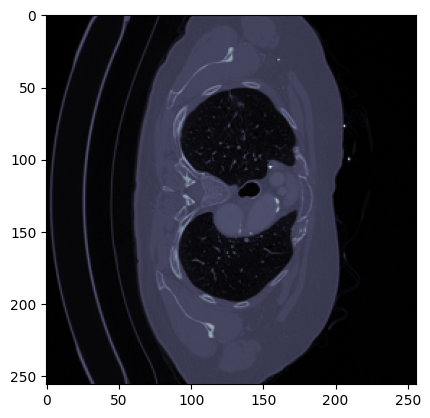

In [6]:
import cv2

data = np.load("Task06_Lung/Preprocessed/all/data/0.npy")
print(data.shape)
# data[0,:,:] = cv2.resize(data[0,:,:], (484,484))
data = np.expand_dims(data, 0)
print(data,data.shape)
plt.imshow(data[0,0,:,:], cmap='bone')

In [7]:
data = torch.Tensor(data)
layer = ViTUnet(num_classes=1, in_channels=1)
res1 = layer.vit_block1(data)
temp = res1.unsqueeze(1)
res2 = layer.decoder(temp)

res1 = res1.detach().numpy()
res2 = res2.detach().numpy()

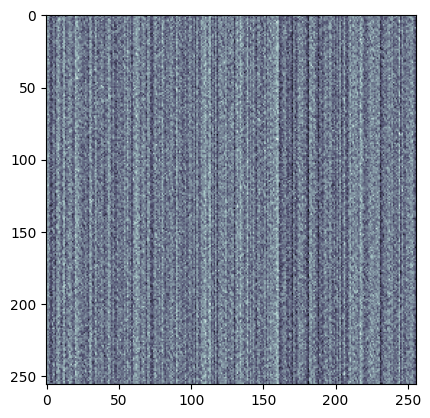

In [8]:
plt.imshow(res1[0,:,:],cmap='bone')
plt.show()

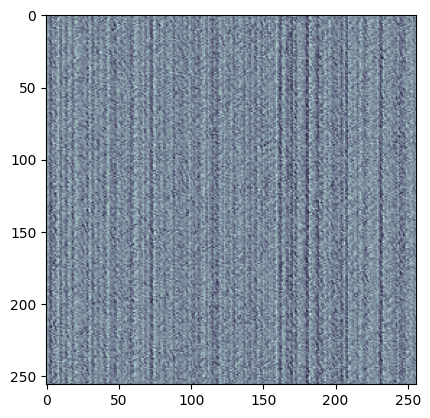

In [9]:
plt.imshow(res2[0,0,:,:],cmap='bone')
plt.show()

In [10]:
# data = torch.Tensor(data)
# layer = ViTClassifier(image_size=256, patch_size=patch_size, num_patches=num_patches, projection_dim=vit_hidden_dim, num_heads=vit_num_heads,
#     mlp_units=[256, 256], dropout_rate=dropout, num_classes=num_classes, use_token_learner=False, token_learner_units=1)
# tl_layer = TokenLearner(8)
# vit = ViTUnet()

In [11]:
# trans_x = layer(data)
# tl_x = tl_layer(trans_x)
# decoder = vit.decoder(tl_x)
# decoder_2 = vit.decoder(trans_x)

In [12]:
# print(trans_x)
# print(tl_x)
# print(decoder)

# trans_x = trans_x.detach().numpy()
# tl_x = tl_x.detach().numpy()
# decoder = decoder.detach().numpy()
# decoder_2 = decoder_2.detach().numpy()

In [13]:
# plt.imshow(trans_x[0,:,:],cmap='bone')
# plt.show()

In [14]:
# plt.imshow(tl_x[0,:,:], cmap='bone')
# plt.show()

In [15]:
# plt.imshow(decoder[0,:,:], cmap='bone')
# plt.show()

In [16]:
# plt.imshow(decoder_2[0,:,:], cmap='bone')
# plt.show()

In [17]:
# print(trans_x.shape, tl_x.shape, decoder.shape, decoder_2.shape)

In [18]:
# models = ['efficientnet-b4', 'efficientnet-b3']

In [19]:
# benchmark = pd.DataFrame(columns=['model_name', 'epochs', 'gflops', 'dice_score', 'iou_score'])

In [20]:
EPOCH = 100

In [21]:
print(torch.cuda.is_available())
device = "cuda:0"

True


In [22]:
class CustomDataset(Dataset):
    def __init__(self, data_path, label_path):
        self.data_path = data_path
        self.label_path = label_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __len__(self):
        return len(os.listdir(self.data_path))

    def __getitem__(self, idx):
        ct = np.load(os.path.join(self.data_path, f"{idx}.npy"))
        mask = np.load(os.path.join(self.label_path, f"{idx}.npy"))

        ct = torch.Tensor(ct).to(self.device)
        mask = torch.Tensor(mask).to(self.device)

        return ct, mask

class DataGenerator:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.ROOT_DATA_PATH = 'Task06_Lung/Preprocessed/all/data/'
        self.ROOT_LABEL_PATH = 'Task06_Lung/Preprocessed/all/label/'
        self.TEST_DATA_PATH = 'Task06_Lung/Preprocessed/test/data/'
        self.TEST_LABEL_PATH = 'Task06_Lung/Preprocessed/test/label/'

    def train_loader(self):
        dataset = CustomDataset(self.ROOT_DATA_PATH, self.ROOT_LABEL_PATH)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def test_loader(self):
        dataset = CustomDataset(self.TEST_DATA_PATH, self.TEST_LABEL_PATH)
        return DataLoader(dataset, batch_size=1, shuffle=False)

In [23]:
batch_size = 4

data_generator = DataGenerator(batch_size)

train_loader = data_generator.train_loader()

test_loader = data_generator.test_loader()

In [24]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):

        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()  # Counter
        denum = pred.sum() + mask.sum()
        dice = (2*counter)/denum

        return dice


In [25]:
def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

c:\Users\kiree\anaconda3\envs\benchmark\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/100, Average Loss: 0.0865
Epoch 2/100, Average Loss: 0.0198
Epoch 3/100, Average Loss: 0.0173
Epoch 4/100, Average Loss: 0.0153
Epoch 5/100, Average Loss: 0.0130
Epoch 6/100, Average Loss: 0.0111
Epoch 7/100, Average Loss: 0.0095
Epoch 8/100, Average Loss: 0.0080
Epoch 9/100, Average Loss: 0.0067
Epoch 10/100, Average Loss: 0.0058
Epoch 11/100, Average Loss: 0.0052
Epoch 12/100, Average Loss: 0.0048
Epoch 13/100, Average Loss: 0.0045
Epoch 14/100, Average Loss: 0.0043
Epoch 15/100, Average Loss: 0.0041
Epoch 16/100, Average Loss: 0.0038
Epoch 17/100, Average Loss: 0.0038
Epoch 18/100, Average Loss: 0.0036
Epoch 19/100, Average Loss: 0.0036
Epoch 20/100, Average Loss: 0.0034
Epoch 21/100, Average Loss: 0.0033
Epoch 22/100, Average Loss: 0.0033
Epoch 23/100, Average Loss: 0.0032
Epoch 24/100, Average Loss: 0.0031
Epoch 25/100, Average Loss: 0.0031
Epoch 26/100, Average Loss: 0.0031
Epoch 27/100, Average Loss: 0.0030
Epoch 28/100, Average Loss: 0.0029
Epoch 29/100, Average Loss: 0

Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::unflatten encountered 3 time(s)
Unsupported operator aten::mul encountered 12 time(s)
Unsupported operator aten::scaled_dot_product_attention encountered 3 time(s)
Unsupported operator aten::add encountered 6 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
vit_block1.transformer.layers.0.self_attn.out_proj, vit_block1.transformer.layers.1.self_attn.out_proj, vit_block1.transformer.layers.2.self_attn.out_proj


Dice Score: tensor(0.8685) 
IoU Score: 0.768 
Flops: 11.0


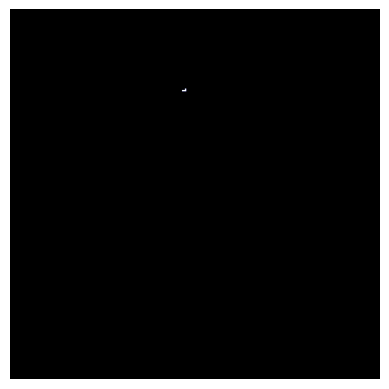

In [26]:
# for name in tqdm(models):

# #     model =  smp.Unet(
# #     encoder_name=name,        
# #     encoder_weights="imagenet",     
# #     in_channels=1,                  
# #     classes=1,                    
# # )
    
model = ViTUnet(num_classes=1, in_channels=1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
torch.device(device=device)
model = model.to(device)

for epoch in range(EPOCH):
    model.train()
    total_loss = 0.0

    for batch_idx, (ct, mask) in enumerate(train_loader):
        ct, mask = ct.to(device), mask.to(device)
        # print(ct.shape)
        # print(mask.shape)

        outputs = model(ct)
        # print(outputs.shape)

        loss = criterion(outputs, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{EPOCH}, Average Loss: {average_loss:.4f}")

preds = []
labels = []

for batch_idx, (ct, mask) in enumerate(test_loader):

    ct, mask = ct.to(device), mask.to(device)
        
    with torch.no_grad():
        pred = model(ct)
        
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    pred = np.where(pred > 0, 1, 0)

    preds.append(pred)
    labels.append(mask)
    
preds = np.array(preds)
labels = np.array(labels)

dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels))
iou_score = iou(labels, preds)

data = torch.rand(4, 1, 256, 256).to(device)
flops = FlopCountAnalysis(model, data)
print("Dice Score:",dice_score,"\nIoU Score:", iou_score,"\nFlops:", flops.total() // 1e9)

import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML
fig = plt.figure()
camera = Camera(fig)

for i in range(len(preds)):  # axial view
    plt.imshow(preds[i][0, 0, :, :], cmap="bone")
    plt.axis("off")
    camera.snap()

animation = camera.animate()
HTML(animation.to_html5_video())
plt.show()
    # new_row = {'model_name': name, 'epochs':EPOCH, 'gflops': flops, 'dice_score': dice_score, 'iou_score': iou_score}
    # benchmark = pd.concat([benchmark, pd.DataFrame([new_row])], ignore_index=True)

HTML(animation.to_html5_video())

In [27]:
# benchmark

In [28]:
# file_name = 'benchmark.xlsx'
# benchmark.to_excel(file_name)